### Import required libraries

In [1]:
# model
import tensorflow as tf
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

# data processing 
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# evaluation
import keras.metrics as km
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

### Set data path and image variables

In [ ]:
# data path
data_dir = "/content/drive/MyDrive/dataset_categorized/Video_Dataset/"

# frame generation parameters
img_height , img_width = 64, 64
seq_len = 60

# labels 
classes = ["bad_back_round", "bad_back_warp", "bad_head", "bad_inner_thigh", "bad_shallow", "bad_toe", "good"]

### Create functions for processing videos

In [ ]:
#  Creating frames from videos
 
def frames_extraction(video_path):
    """
    Parse video file and create individual frame images

    Parameters
    ----------
    video_path : str
        The file location of the video

    Returns
    -------
    frames_list
        a list of images parsed from video
    """
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list
 
def create_data(input_dir):
    """
    Create vectorized feature and label data from videos

    Parameters
    ----------
    input_dir : str
        Directory path to data

    Returns
    -------
    X
        Array of image feature data
    Y
        Array of label data
    """  
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
           frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
           if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [ ]:
# checking data path is correctly implemented
print(os.listdir(os.path.join(data_dir, 'bad_back_round')))

['0918_squat_000020.mp4', '0918_squat_000017.mp4', '0918_squat_000018.mp4', '0918_squat_000058.mp4', '0918_squat_000016.mp4', '0918_squat_000021.mp4', '0918_squat_000022.mp4', '0918_squat_000019.mp4', '0922_squat_000017.mp4', '0918_squat_000059.mp4', '0922_squat_000018.mp4', '0918_squat_000064.mp4', '0918_squat_000060.mp4', '0918_squat_000061.mp4', '0918_squat_000065.mp4', '0918_squat_000063.mp4', '0922_squat_000016.mp4', '0918_squat_000062.mp4', '0922_squat_000080.mp4', '0922_squat_000021.mp4', '0922_squat_000076.mp4', '0922_squat_000023.mp4', '0922_squat_000118.mp4', '0922_squat_000119.mp4', '0922_squat_000115.mp4', '0922_squat_000019.mp4', '0922_squat_000079.mp4', '0922_squat_000075.mp4', '0922_squat_000116.mp4', '0922_squat_000073.mp4', '0922_squat_000077.mp4', '0922_squat_000022.mp4', '0922_squat_000078.mp4', '0922_squat_000074.mp4', '0922_squat_000117.mp4', '0922_squat_000020.mp4', '0922_squat_000176.mp4', '0922_squat_000177.mp4', '0922_squat_000174.mp4', '0922_squat_000173.mp4',

### Create and split data for train and test

In [11]:
distribution = {'good': [311],
           'bad_back_round': [288],
           'bad_back_warp': [320],
           'bad_inner_thigh': [235],
           'bad_toe': [305],
           'bad_shallow': [325],
           'bad_head': [280]}

df_dist = pd.DataFrame.from_dict(distribution)
df_dist = df_dist.T
df_dist['%'] = round(((df_dist[0]/2064)*100), 2)
df_dist = df_dist.rename(columns={0:'Videos'})
df_dist

,Videos,%
good,311,15.07
bad_back_round,288,13.95
bad_back_warp,320,15.50
bad_inner_thigh,235,11.39
bad_toe,305,14.78
bad_shallow,325,15.75
bad_head,280,13.57


In [ ]:
# create data
X, Y = create_data(data_dir)
 
# split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

bad_shallow
bad_head
bad_back_round
good
bad_toe
bad_back_warp
bad_inner_thigh


### Initialize model

In [ ]:
# instantiating model
model = Sequential()
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu',input_shape=(seq_len, img_height, img_width, 3)))
model.add(MaxPooling3D(pool_size = (2, 2, 2)))
model.add(BatchNormalization())
model.add(Conv3D(filters = 128, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size = (2, 2, 2)))
model.add(BatchNormalization())
model.add(Conv3D(filters = 256, kernel_size=(3, 3, 3), activation ='relu'))
model.add(Conv3D(512, kernel_size=(1, 1, 1), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 1, 1)))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

model.summary()

opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 58, 62, 62, 64)    5248      
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 29, 31, 31, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 29, 31, 31, 64)   256       
 chNormalization)                                                
                                                                 
 conv3d_41 (Conv3D)          (None, 27, 29, 29, 128)   221312    
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 13, 14, 14, 128)  0         
 g3D)                                                            
                                                     

### Train model

In [ ]:
# early stopping if validation loss does not improve for 7 epochs
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
 
history = model.fit(x=X_train, y=y_train, epochs=100, batch_size=8 , shuffle=True, validation_split=0.2, callbacks=callbacks)

Epoch 1/100
165/165 [==============================] - 44s 264ms/step - loss: 2.4080 - accuracy: 0.1621 - val_loss: 1.9343 - val_accuracy: 0.1611
Epoch 2/100
165/165 [==============================] - 44s 266ms/step - loss: 1.8405 - accuracy: 0.2443 - val_loss: 1.8306 - val_accuracy: 0.2614
Epoch 3/100
165/165 [==============================] - 44s 268ms/step - loss: 1.6249 - accuracy: 0.3607 - val_loss: 1.8259 - val_accuracy: 0.2614
Epoch 4/100
165/165 [==============================] - 44s 269ms/step - loss: 1.2278 - accuracy: 0.5479 - val_loss: 1.7090 - val_accuracy: 0.3799
Epoch 5/100
165/165 [==============================] - 45s 270ms/step - loss: 0.9016 - accuracy: 0.6697 - val_loss: 1.8573 - val_accuracy: 0.4043
Epoch 6/100
165/165 [==============================] - 45s 271ms/step - loss: 0.5439 - accuracy: 0.8311 - val_loss: 1.8397 - val_accuracy: 0.3891
Epoch 7/100
165/165 [==============================] - 45s 271ms/step - loss: 0.3310 - accuracy: 0.9072 - val_loss: 1.4753 -

### Saving model

In [ ]:
# creating directory
!mkdir /content/drive/MyDrive/CNN_Model

In [ ]:
# saving model
model.save('/content/drive/My Drive/CNN_Model/model_3')

In [ ]:
# testing save model
new_model = tf.keras.models.load_model('/content/drive/My Drive/CNN_Model/model_3')

# Check its architecture
new_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 58, 62, 62, 64)    5248      
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 29, 31, 31, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 29, 31, 31, 64)   256       
 chNormalization)                                                
                                                                 
 conv3d_41 (Conv3D)          (None, 27, 29, 29, 128)   221312    
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 13, 14, 14, 128)  0         
 g3D)                                                            
                                                     

In [ ]:
# Evaluate the restored model
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(X_test).shape)

13/13 - 4s - loss: 1.4452 - accuracy: 0.5645 - 4s/epoch - 273ms/step
Restored model, accuracy: 56.45%
(411, 7)


### Test model and evaluate

In [ ]:
# generate predictions
y_pred = model.predict(X_test)

In [ ]:
# checking shape of predictions
print(y_pred.shape)

(411, 7)


In [ ]:
# checking shape of test data
print(y_test.shape)

(411, 7)


In [ ]:
# vectorizing data
y_pred_vector = np.argmax(y_pred, axis=1)
y_test_vector = np.argmax(y_test, axis=1)

# classification report 
print(classification_report(y_test_vector, y_pred_vector, target_names=classes))

                 precision    recall  f1-score   support

 bad_back_round       0.75      0.67      0.71        49
  bad_back_warp       0.49      0.58      0.53        69
       bad_head       0.46      0.65      0.54        57
bad_inner_thigh       0.62      0.34      0.44        44
    bad_shallow       0.81      0.75      0.78        72
        bad_toe       0.51      0.52      0.51        58
           good       0.43      0.37      0.40        62

       accuracy                           0.56       411
      macro avg       0.58      0.55      0.56       411
   weighted avg       0.58      0.56      0.56       411



In [ ]:
# ROC/AUC Score
print(roc_auc_score(y_test, y_pred))

0.8631771572463853


In [ ]:
# confusion matrix
confusion_matrix(y_test_vector, y_pred_vector)

array([[33, 10,  3,  1,  1,  0,  1],
       [ 7, 40,  9,  3,  1,  1,  8],
       [ 1,  7, 37,  0,  1,  3,  8],
       [ 2,  8,  9, 15,  1,  5,  4],
       [ 0,  2,  5,  1, 54,  7,  3],
       [ 0,  3, 10,  1,  7, 30,  7],
       [ 1, 12,  8,  3,  2, 13, 23]])

In [ ]:
# One-vs-Rest Confusion matrices
multilabel_confusion_matrix(y_test_vector, y_pred_vector)

array([[[351,  11],
        [ 16,  33]],

       [[300,  42],
        [ 29,  40]],

       [[310,  44],
        [ 20,  37]],

       [[358,   9],
        [ 29,  15]],

       [[326,  13],
        [ 18,  54]],

       [[324,  29],
        [ 28,  30]],

       [[318,  31],
        [ 39,  23]]])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


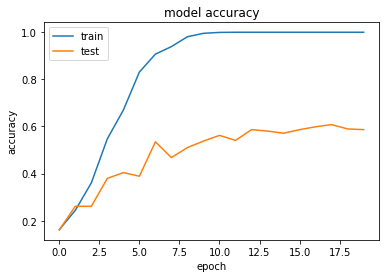

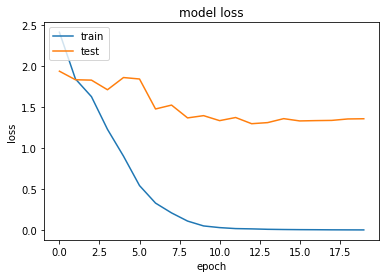

In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Cohen Kappa Score
print(cohen_kappa_score(y_test_vector, y_pred_vector))

0.4359340409244201


In [ ]:
# viewing single prediction
print(y_pred[0])

[0.24561726 0.0843804  0.21297304 0.01345094 0.00258409 0.4224025
 0.01859171]


### Creating function to get labels

In [ ]:
# generate labels for predictions
def get_classes(test_values, predictions, class_names):
    """
    Generate actual and predicted labels from model results

    Parameters
    ----------
    test_values : array
        array of actual test values
    predictions : array
        array of predicted values
    class_names : list of label names

    Returns
    -------
    actual
        a list of actual labels for each index
    predicted
        a list of predicted labels for each index
    """
    actual = []
    predicted = []
    for i in range(len(test_values)):
      v = class_names[np.argmax(test_values[i])]
      actual.append(v)
    for i in range(len(predictions)):
      p = class_names[np.argmax(predictions[i])]
      predicted.append(p)
    return actual, predicted

In [ ]:
# creating dataframe of actual and predicted labels
actual, predicted = get_classes(y_test, y_pred, classes)

zipped = list(zip(actual, predicted))

df = pd.DataFrame(zipped, columns=['Actual','Predicted']) 
df

,Actual,Predicted
0,good,bad_toe
1,bad_inner_thigh,bad_back_warp
2,bad_back_round,bad_back_round
3,good,good
4,bad_back_warp,bad_back_warp
...,...,...
406,bad_back_warp,bad_back_round
407,good,good
408,bad_back_round,bad_back_round
409,good,bad_head


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Actual     411 non-null    object
 1   Predicted  411 non-null    object
dtypes: object(2)
memory usage: 6.5+ KB


In [ ]:
df[df['Actual'] == df['Predicted']]

,Actual,Predicted
2,bad_back_round,bad_back_round
3,good,good
4,bad_back_warp,bad_back_warp
5,bad_toe,bad_toe
9,bad_back_round,bad_back_round
...,...,...
397,bad_inner_thigh,bad_inner_thigh
398,bad_toe,bad_toe
405,bad_shallow,bad_shallow
407,good,good


### Generating Random Rate Baseline

In [ ]:
counts = df['Actual'].value_counts().to_list()

In [ ]:
total = 411
random_proba = [(x / total)**2 for x in counts]
baseline = round((np.sum(weighted_proba)*100), 2)
print(f'Baseline probability using Random Rate: {baseline}%')

Baseline probability using Random Rate: 14.65%
